<a href="https://colab.research.google.com/github/marcoullmann/enron/blob/master/enron_topicmodelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/enron/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/enron


In [2]:
import os, sys, email, re
!pip install numpy==1.18.0
!pip install pyarrow
import numpy as np 
import pandas as pd
import math
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud

# Gensim
!pip install gensim==3.8.1
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import glob
import pickle

!pip install pyldavis
# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

num_topics=32

     |████████████████████████████████| 20.1MB 1.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5


     |████████████████████████████████| 24.2MB 1.9MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.6MB 6.5MB/s 
     |████████████████████████████████| 552kB 43.7MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=321611ebd521321949d5bcb0ed3177c45027ee6b5e9fa1ec1d03cd93fd83ffa9
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=8bedb41815e17290fe24b4a86c2725a8ac6e1896d9809086ca462db87369f12f
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [0]:
files = glob.glob("./data/emails_df_*.pkl")
dfs = []
for file in files:
  df = pd.read_pickle(file)
  df.drop(df.columns.difference(['Message-ID','trigram_lemma_content']), 1, inplace=True)
  dfs.append(df)
emails_df = pd.concat(dfs)

In [0]:
texts = emails_df['trigram_lemma_content']
# Create Dictionary
id2word = corpora.Dictionary(texts)
print(id2word)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Dictionary(582844 unique tokens: ['forecast', 'austin', 'better', 'boat', 'business']...)


In [0]:
len(corpus)

517401

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=0,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [0]:
print(lda_model.print_topics())

[(0, '0.004*"com" + 0.003*"enron" + 0.003*"agreement" + 0.002*"exhibit" + 0.001*"message" + 0.001*"attach" + 0.001*"doc" + 0.001*"need" + 0.001*"mail" + 0.001*"document"'), (1, '0.007*"enron" + 0.004*"com" + 0.003*"change" + 0.003*"information" + 0.002*"may" + 0.002*"mail" + 0.002*"kay" + 0.002*"contract" + 0.002*"use" + 0.002*"letter"'), (2, '0.004*"enron" + 0.003*"com" + 0.003*"agreement" + 0.002*"kay" + 0.002*"abb" + 0.002*"get" + 0.002*"power" + 0.001*"mann" + 0.001*"shall" + 0.001*"company"'), (3, '0.006*"com" + 0.005*"enron" + 0.005*"kay" + 0.003*"exhibit" + 0.003*"mann" + 0.002*"message" + 0.002*"agreement" + 0.002*"contract" + 0.002*"change" + 0.002*"original"'), (4, '0.026*"com" + 0.019*"enron" + 0.012*"kay" + 0.007*"mann" + 0.006*"doc" + 0.005*"agreement" + 0.004*"information" + 0.004*"attach" + 0.004*"mail" + 0.003*"draft"'), (5, '0.003*"com" + 0.003*"agreement" + 0.003*"enron" + 0.002*"message" + 0.002*"shall" + 0.002*"performance" + 0.002*"exhibit" + 0.002*"kay" + 0.002*"u

In [0]:
# Visualize the topics
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

In [0]:
pyLDAvis.save_html(vis, 'lda.html')

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -8.223963138646003


In [0]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48122962710708056


In [0]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet'

In [0]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

In [0]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.599055117610582


In [0]:
# Show Topics
print(ldamallet.show_topics(formatted=True))


[(30, '0.009*"committee" + 0.008*"state" + 0.008*"bush" + 0.007*"house" + 0.007*"nytime" + 0.006*"president" + 0.005*"national" + 0.005*"year" + 0.005*"time" + 0.005*"news"'), (26, '0.059*"deal" + 0.037*"gas" + 0.017*"contract" + 0.016*"chris" + 0.015*"volume" + 0.015*"capacity" + 0.014*"day" + 0.011*"change" + 0.011*"pipeline" + 0.010*"book"'), (3, '0.067*"call" + 0.057*"meeting" + 0.028*"work" + 0.026*"discuss" + 0.020*"give" + 0.020*"meet" + 0.018*"talk" + 0.018*"time" + 0.018*"week" + 0.017*"office"'), (14, '0.029*"customer" + 0.028*"rate" + 0.027*"cost" + 0.018*"pay" + 0.014*"bill" + 0.012*"credit" + 0.012*"amount" + 0.011*"charge" + 0.010*"payment" + 0.010*"issue"'), (16, '0.031*"employee" + 0.020*"process" + 0.018*"project" + 0.017*"review" + 0.016*"plan" + 0.016*"work" + 0.014*"provide" + 0.013*"question" + 0.011*"complete" + 0.010*"feedback"'), (8, '0.092*"date" + 0.082*"schedule" + 0.049*"final" + 0.048*"hour" + 0.040*"file" + 0.037*"find" + 0.031*"type" + 0.027*"start" + 0.0

In [0]:
ldamallet.print_topics(num_topics=num_topics)

[(0,
  '0.016*"power" + 0.013*"company" + 0.013*"project" + 0.010*"government" + 0.008*"year" + 0.008*"enron" + 0.008*"india" + 0.008*"state" + 0.007*"market" + 0.005*"country"'),
 (1,
  '0.028*"mark" + 0.021*"credit" + 0.021*"legal" + 0.019*"fax" + 0.018*"forward" + 0.017*"agreement" + 0.016*"master" + 0.016*"sara_shackleton" + 0.015*"america" + 0.015*"north"'),
 (2,
  '0.011*"make" + 0.010*"people" + 0.009*"time" + 0.008*"good" + 0.008*"man" + 0.007*"day" + 0.006*"life" + 0.006*"friend" + 0.006*"give" + 0.006*"thing"'),
 (3,
  '0.067*"call" + 0.057*"meeting" + 0.028*"work" + 0.026*"discuss" + 0.020*"give" + 0.020*"meet" + 0.018*"talk" + 0.018*"time" + 0.018*"week" + 0.017*"office"'),
 (4,
  '0.042*"price" + 0.022*"market" + 0.017*"day" + 0.014*"product" + 0.013*"month" + 0.012*"high" + 0.012*"term" + 0.011*"transaction" + 0.009*"trade" + 0.009*"area"'),
 (5,
  '0.042*"market" + 0.026*"ferc" + 0.015*"iso" + 0.014*"transmission" + 0.013*"order" + 0.012*"price" + 0.010*"commission" + 0.

In [0]:
topics = ldamallet.show_topics(formatted=False,num_topics=num_topics)

In [16]:
topics

[(0,
  [('power', 0.01606628973304253),
   ('company', 0.013352970402127044),
   ('project', 0.01309945543033945),
   ('government', 0.010088743536365437),
   ('year', 0.008498070050796069),
   ('enron', 0.00836111878107165),
   ('india', 0.00828665983830886),
   ('state', 0.007757469495101887),
   ('market', 0.006759365095686389),
   ('country', 0.005304313255863531)]),
 (1,
  [('mark', 0.028114469261747318),
   ('credit', 0.021246072541312264),
   ('legal', 0.020827581824794807),
   ('fax', 0.01898600356703082),
   ('forward', 0.017610571382246355),
   ('agreement', 0.017287391378653028),
   ('master', 0.016287724418385545),
   ('sara_shackleton', 0.015503875968992248),
   ('america', 0.0147085245025219),
   ('north', 0.014644984027239145)]),
 (2,
  [('make', 0.010631562871464587),
   ('people', 0.010484279924609258),
   ('time', 0.00896749216114839),
   ('good', 0.008143614015354588),
   ('man', 0.007589830135178555),
   ('day', 0.007271698969971046),
   ('life', 0.00643558501013080

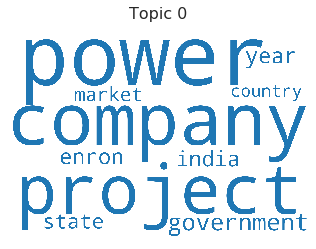

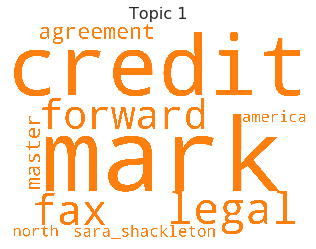

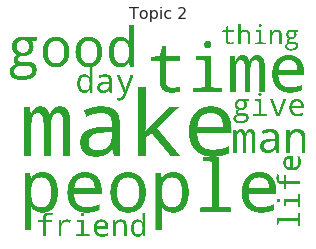

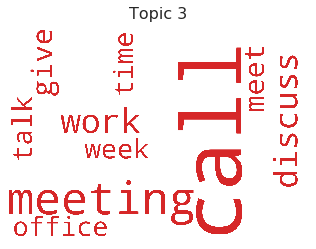

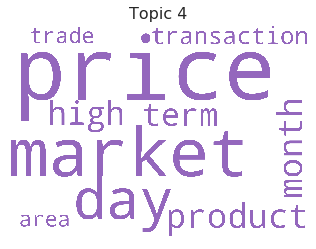

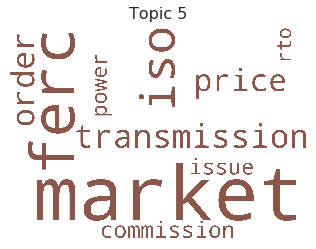

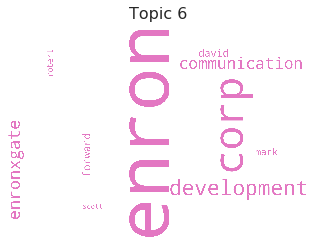

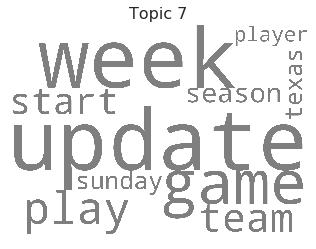

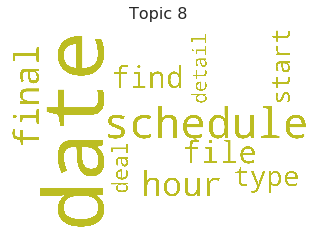

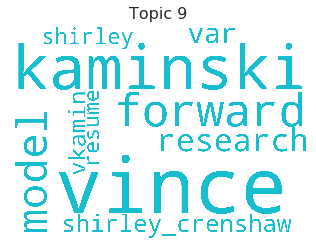

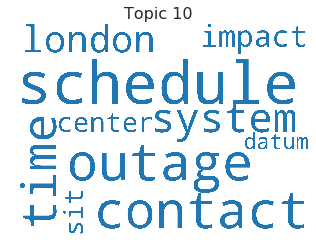

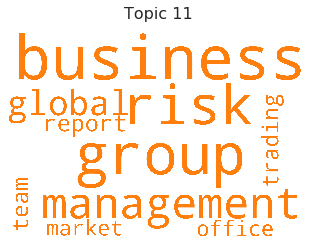

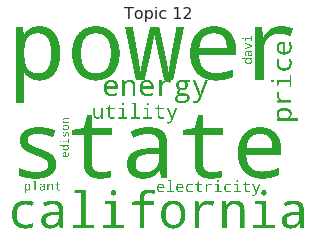

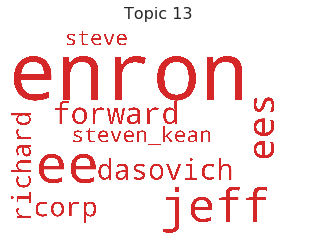

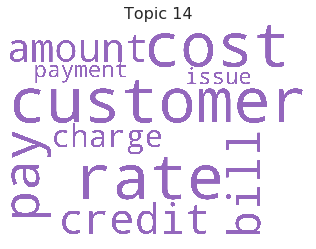

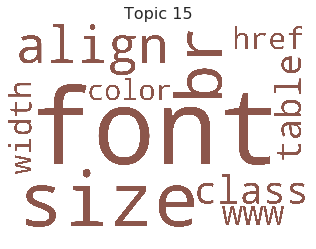

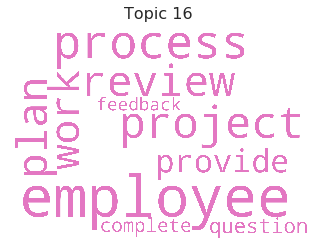

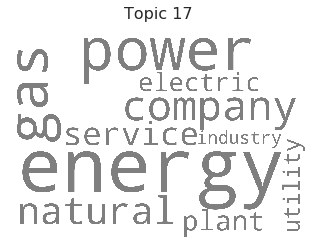

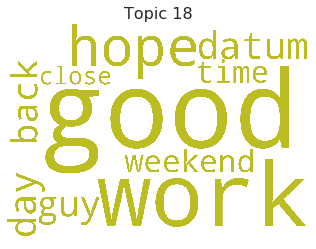

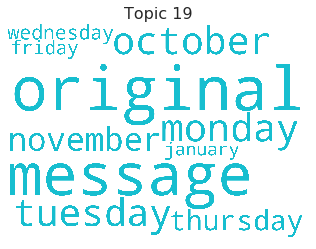

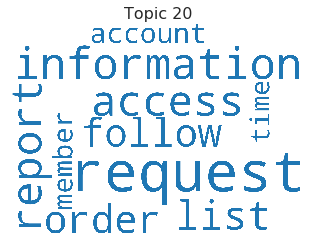

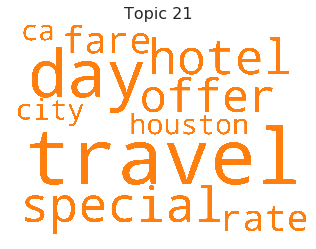

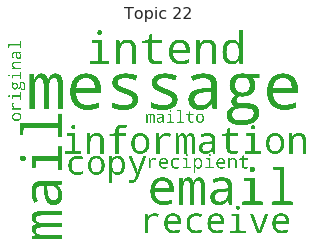

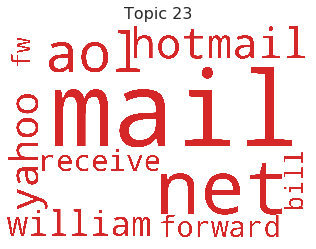

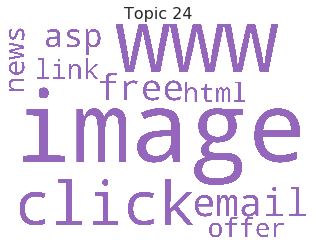

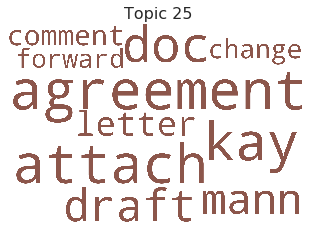

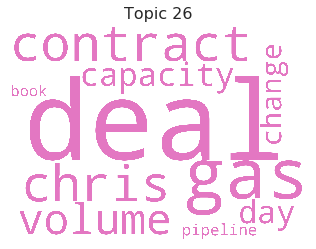

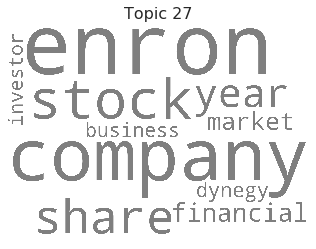

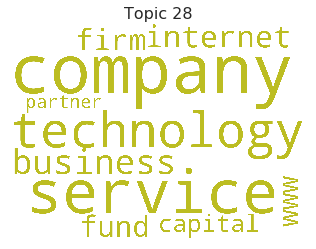

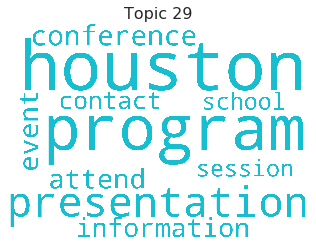

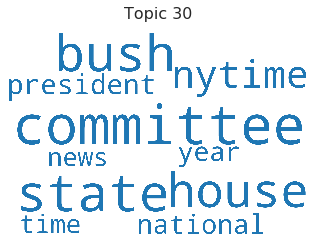

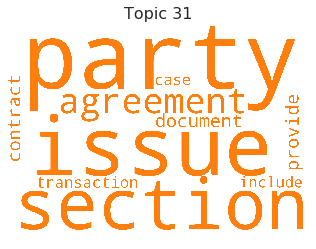

In [13]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=gensim.parsing.preprocessing.STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  margin=0,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[topic[0] % 10],
                  prefer_horizontal=0.5)
topics = ldamallet.show_topics(formatted=False, num_topics=num_topics, num_words=20)

for topic in topics:
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words)
    plt.imshow(cloud)
    plt.title('Topic ' + str(topic[0]), fontdict=dict(size=16))
    plt.axis('off')
    plt.show()



In [0]:
topic_vector = ldamallet[corpus]

In [0]:
# write model
ldamallet.save("./model/ldamallet.model")
id2word.save("./model/id2word.dict")
pickle.dump(corpus, open('./model/corpus.pkl', 'wb'))
pickle.dump(topic_vector, open('./model/topic_vector.pkl', 'wb'))

In [0]:
# read model
topic_vector = pickle.load( open("./model/topic_vector.pkl", "rb") )
ldamallet = gensim.models.wrappers.LdaMallet.load("./model/ldamallet.model")
id2word = corpora.Dictionary.load("./model/id2word.dict")
corpus = pickle.load( open("./model/corpus.pkl", "rb") )

In [0]:
len(topic_vector)

517401

In [0]:
ldamallet.print_topic(8,100)

'0.092*"date" + 0.082*"schedule" + 0.049*"final" + 0.048*"hour" + 0.040*"file" + 0.037*"find" + 0.031*"type" + 0.027*"start" + 0.019*"deal" + 0.015*"detail" + 0.015*"california" + 0.015*"scheduling" + 0.014*"iso" + 0.014*"message" + 0.013*"tran" + 0.013*"load" + 0.012*"time" + 0.012*"prefer" + 0.012*"point" + 0.011*"datum" + 0.011*"sale" + 0.011*"epmi" + 0.010*"hourahead" + 0.009*"follow" + 0.009*"txt" + 0.009*"ancillary" + 0.009*"portland_westdesk" + 0.008*"log" + 0.008*"parse" + 0.007*"variance" + 0.007*"tie" + 0.007*"trading" + 0.006*"kate" + 0.006*"type_trans" + 0.005*"trade" + 0.005*"description" + 0.005*"attached" + 0.005*"energy" + 0.005*"sc" + 0.004*"award_variance_detect_log" + 0.004*"bad" + 0.004*"import_export" + 0.004*"desk" + 0.004*"preferred" + 0.004*"central" + 0.003*"status" + 0.003*"variance_detect" + 0.003*"firm" + 0.003*"mkt_type_trans" + 0.003*"sc_epmi_mkt" + 0.003*"sheet" + 0.003*"real" + 0.003*"wheel" + 0.003*"bpa" + 0.003*"error" + 0.003*"final_sc_ectrt" + 0.003*

In [0]:
topic_vector_df = pd.DataFrame(topic_vector, columns=range(num_topics)).applymap(lambda x: x[1])
topic_vector_df['id'] = topic_vector_df.index
topic_vector_long_df = pd.melt(topic_vector_df, id_vars=['id'], value_vars=range(num_topics), var_name='topic', value_name='prob')

In [16]:
topic_vector_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,id
0,0.030637,0.030637,0.030637,0.030637,0.048066,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.032816,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0
1,0.018027,0.019150,0.049453,0.143729,0.018027,0.021395,0.015783,0.038230,0.016905,0.016905,0.019150,0.041597,0.019150,0.015783,0.015783,0.028129,0.028129,0.018027,0.053942,0.015783,0.019150,0.102203,0.020272,0.015783,0.016905,0.016905,0.015783,0.020272,0.031496,0.074144,0.028129,0.025884,1
2,0.032185,0.030048,0.030048,0.030048,0.032185,0.030048,0.030048,0.030048,0.030048,0.030048,0.047142,0.034322,0.030048,0.030048,0.034322,0.030048,0.034322,0.032185,0.030048,0.030048,0.030048,0.030048,0.030048,0.030048,0.030048,0.030048,0.030048,0.030048,0.032185,0.030048,0.030048,0.030048,2
3,0.025202,0.026994,0.026994,0.052083,0.032370,0.025202,0.030578,0.025202,0.052083,0.025202,0.039539,0.037746,0.028786,0.025202,0.026994,0.025202,0.053875,0.028786,0.041331,0.032370,0.025202,0.028786,0.028786,0.025202,0.026994,0.028786,0.032370,0.035954,0.026994,0.026994,0.026994,0.025202,3
4,0.032185,0.030048,0.034322,0.030048,0.030048,0.030048,0.030048,0.038595,0.030048,0.030048,0.030048,0.030048,0.032185,0.030048,0.030048,0.030048,0.030048,0.030048,0.034322,0.042869,0.030048,0.030048,0.032185,0.030048,0.030048,0.030048,0.030048,0.030048,0.030048,0.032185,0.030048,0.030048,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517396,0.026483,0.096163,0.030250,0.032133,0.026483,0.030250,0.026483,0.026483,0.039666,0.026483,0.032133,0.030250,0.026483,0.030250,0.026483,0.026483,0.028366,0.026483,0.035899,0.026483,0.034016,0.026483,0.026483,0.028366,0.026483,0.034016,0.026483,0.028366,0.026483,0.032133,0.032133,0.028366,517396
517397,0.030771,0.036518,0.026940,0.057591,0.036518,0.028855,0.026940,0.026940,0.026940,0.026940,0.026940,0.028855,0.028855,0.026940,0.040350,0.026940,0.030771,0.028855,0.026940,0.026940,0.026940,0.028855,0.026940,0.026940,0.026940,0.042265,0.026940,0.032687,0.038434,0.026940,0.026940,0.051844,517397
517398,0.028916,0.271853,0.021383,0.110523,0.021383,0.038960,0.031427,0.018872,0.010711,0.010083,0.011339,0.017616,0.026405,0.014477,0.020755,0.009455,0.019499,0.011966,0.022638,0.011339,0.018244,0.014477,0.015105,0.011966,0.010083,0.014477,0.065325,0.023894,0.013222,0.018872,0.021383,0.043354,517398
517399,0.029362,0.080044,0.027412,0.027412,0.027412,0.027412,0.027412,0.027412,0.027412,0.027412,0.027412,0.037159,0.027412,0.029362,0.027412,0.027412,0.029362,0.029362,0.029362,0.031311,0.041058,0.029362,0.037159,0.029362,0.041058,0.029362,0.027412,0.027412,0.027412,0.027412,0.027412,0.031311,517399


In [0]:
print(np.mean(topic_vector_long_df['prob']))

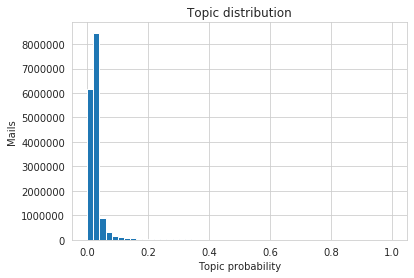

In [0]:
topic_vector_long_df['prob'].plot.hist(grid=True, bins=50, rwidth=1)
plt.title('Topic distribution')
plt.xlabel('Topic probability')
plt.ylabel('Mails')
plt.grid(axis='y', alpha=1)

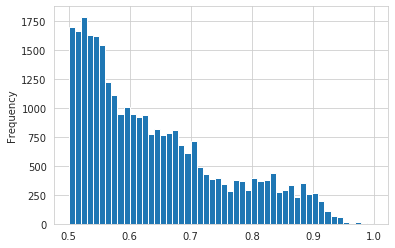

In [0]:
topic_vector_long_df[(topic_vector_long_df.prob > 0.5)]['prob'].plot.hist(grid=True, bins=50, rwidth=1)

In [0]:
topic_vector_long_df.groupby('topic')['prob'].agg('mean').to_frame().reset_index().sort_values(by='prob', ascending=False)

,topic,prob
1,1,0.039481
6,6,0.039390
26,26,0.037597
25,25,0.037099
3,3,0.036193
19,19,0.035599
20,20,0.034227
18,18,0.034217
2,2,0.033925
29,29,0.033846


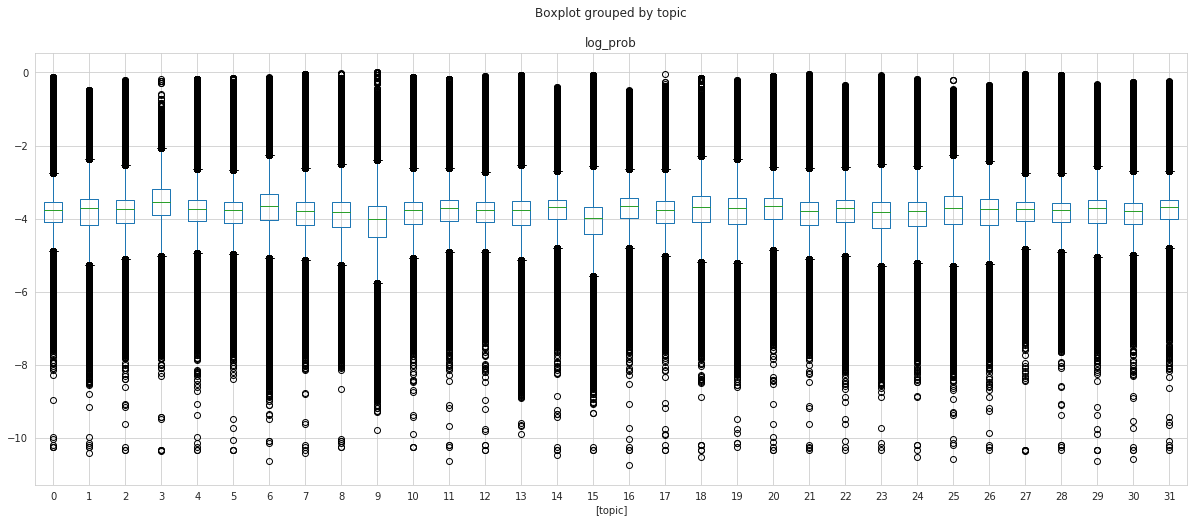

In [0]:
topic_vector_long_df['log_prob'] = np.log(topic_vector_long_df['prob'])
topic_vector_long_df.boxplot(column=['log_prob'], by=['topic'], figsize=(20,8))

In [0]:
non_relevant_topics = [6,8,9,13,15,19,22,23,24,25]
topic_vector_long_relevant_df = topic_vector_long_df[~topic_vector_long_df.topic.isin(non_relevant_topics)]

In [0]:
a = topic_vector_long_relevant_df.groupby(['topic'])['prob'].agg('sum').to_frame().reset_index().rename(columns={"prob": "prob_all"})
b = topic_vector_long_relevant_top3_df.groupby(['topic'])['prob'].agg('sum').to_frame().reset_index().rename(columns={"prob": "prob_top3"}).drop(columns=['topic'])
c = pd.concat([a,b], axis=1).sort_values(by='prob_all', ascending=False)

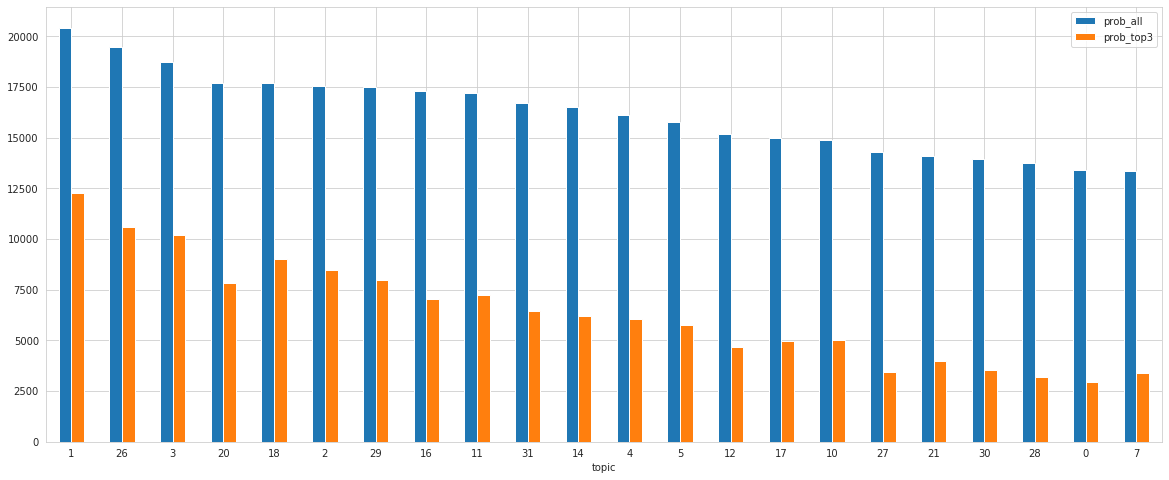

In [0]:
c.plot.bar(x='topic', rot=0, figsize=(20,8))

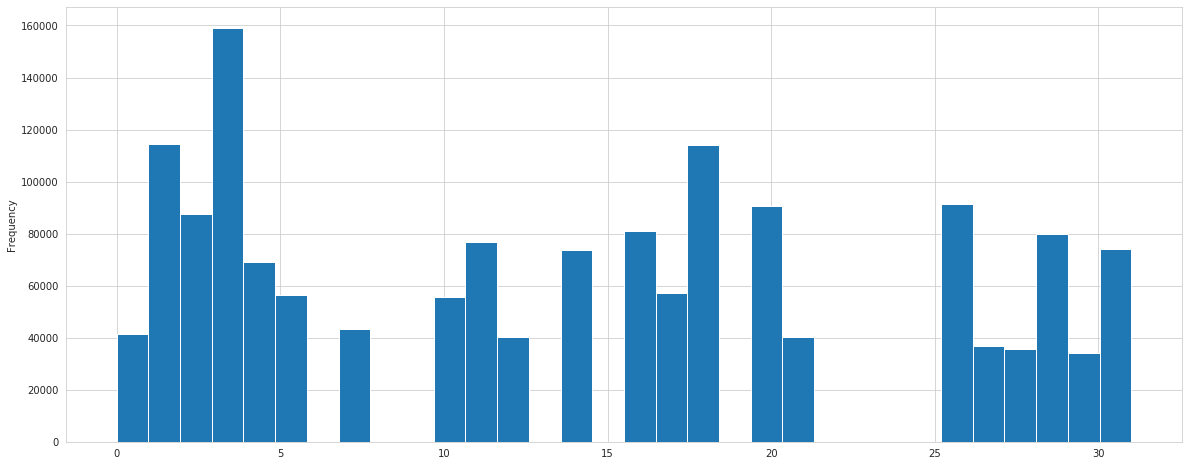

In [0]:
topic_vector_long_relevant_top3_df['topic'].plot.hist(grid=True, bins=32, figsize=(20,8))

In [0]:
i=0
j=0
topic_relevance = topic_vector_long_relevant_df.sort_values(['id','prob'],ascending=False)
topic_relevance['topic_ind']=0
ids = topic_relevance.iloc[0]['id']

for j in range(0,len(topic_relevance)):
  if (ids == topic_relevance.iloc[j]['id']):
    i = i+1
  else:
    ids = topic_relevance.iloc[j]['id']
    i=0
  topic_relevance.iat[j, 3] = i
topic_relevance

,id,topic,prob,topic_ind
1034801,517400,1,0.074832,1
10865420,517400,20,0.038434,2
2069603,517400,3,0.034602,3
6208811,517400,11,0.034602,4
4139207,517400,7,0.030771,5
3104405,517400,5,0.028855,6
8795816,517400,16,0.028855,7
9313217,517400,17,0.028855,8
9830618,517400,18,0.028855,9
14487227,517400,27,0.028855,10


In [0]:
pickle.dump(topic_relevance, open('./model/topic_relevance.pkl', 'wb'))

In [0]:
topic_relevance = pickle.load( open("./model/topic_relevance.pkl", "rb") )

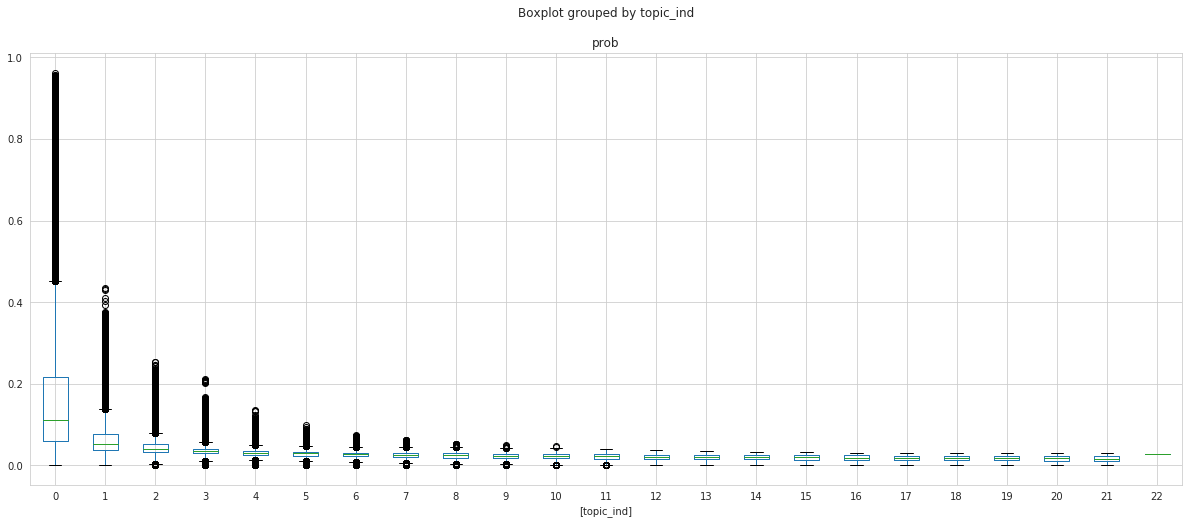

In [0]:
topic_relevance.boxplot(column=['prob'], by=['topic_ind'], figsize=(20,8))

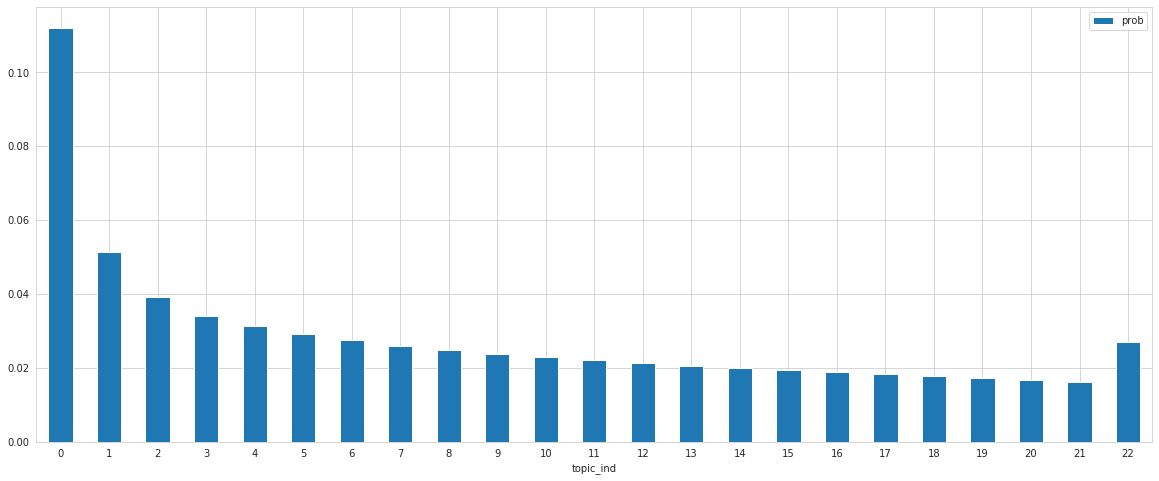

In [0]:
topic_relevance.groupby('topic_ind')['prob'].agg('mean').to_frame().reset_index().plot.bar(x='topic_ind', rot=0, figsize=(20,8))

In [0]:
topic_relevance[(topic_relevance.topic_ind == 22)]

,id,topic,prob,topic_ind
16039430,517400,30,0.02694,22


In [0]:
topic_vector_long_relevant_top3_df = topic_vector_long_relevant_df.sort_values(['prob','id'],ascending=False).groupby('id').head(3)

In [0]:
topic_vector_long_relevant_top3_df.shape

(1552203, 3)

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

limit=36; start=26; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))